In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Background Subtraction
Also known as foreground detection, it's a process of separating out foreground objects from background, in order to further process on the objects. Background subtraction is a widely used approach for detecting moving objects in videos from static cameras.

We'll discuss all conventional approaches below

In [2]:
# We'll be using the following video for test
import io
import base64
from IPython.display import HTML

video = io.open('../resources/bg_sub.mp4', 'rb').read()
encoded = base64.b64encode(video)
HTML(
    '''
    <video alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
    </video>
    '''.format(encoded.decode('ascii'))
)

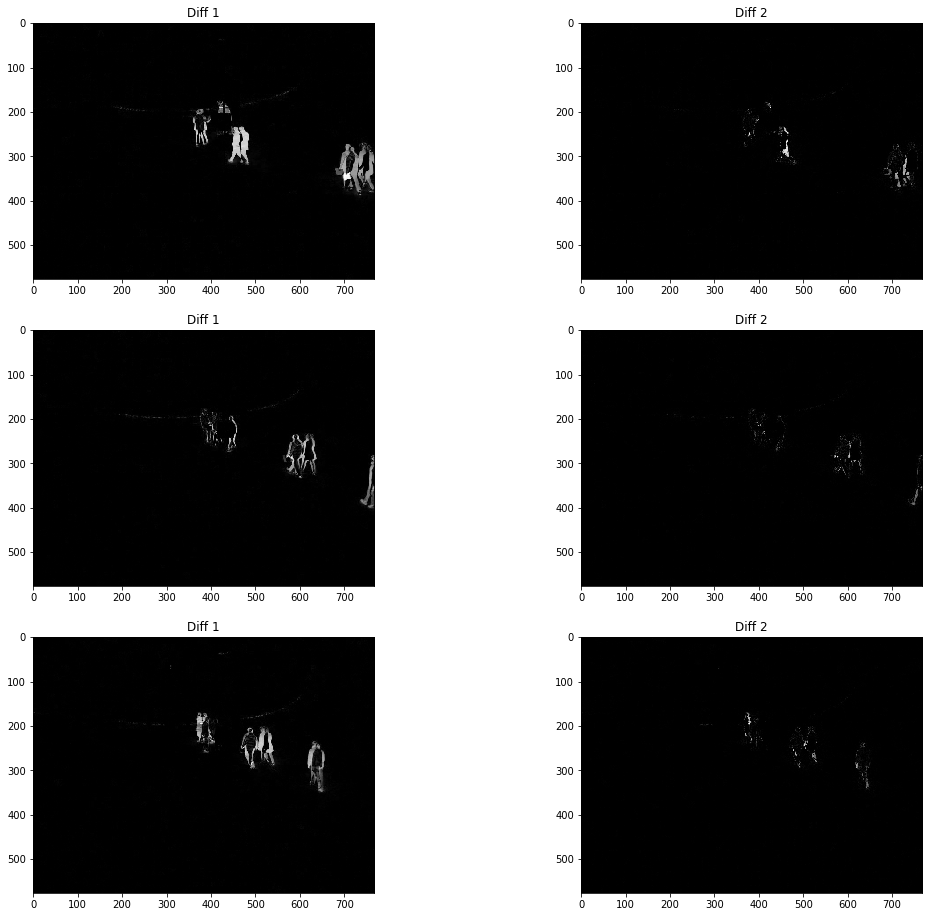

In [3]:
# Frame differencing
cap = cv2.VideoCapture("../resources/bg_sub.mp4")

def frame_diff1(prev_frame, cur_frame, next_frame):
    diff_frames1 = cv2.absdiff(next_frame, cur_frame)
    diff_frames2 = cv2.absdiff(cur_frame, prev_frame)
    return cv2.bitwise_and(diff_frames1, diff_frames2)

def frame_diff2(background, frame, alpha=0.01):
    background = frame * alpha + background * (1 - alpha)
    return cv2.absdiff(background.astype(np.uint8), frame)

def get_frame(cap):
    ret, frame = cap.read()
    if frame is None: return None
    return cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

prev_frame = get_frame(cap)
cur_frame = get_frame(cap)
next_frame = get_frame(cap)

fig = plt.figure()
fig.set_size_inches(18, 16)
batch = 0

while True:
    out1 = frame_diff1(prev_frame, cur_frame, next_frame)
    out2 = frame_diff2(prev_frame, cur_frame)
#     cv2.imshow("Object Movement", out1)

    prev_frame = cur_frame
    cur_frame = next_frame
    next_frame = get_frame(cap)
    if next_frame is None: break
        
    batch += 1
    if batch % 20 == 0:
        try:
            plt.title("Diff 1")
            plt.subplot(3, 2, batch // 10)
            plt.imshow(out1, cmap='gray')
            plt.title("Diff 2")
            plt.subplot(3, 2, batch // 10 - 1)
            plt.imshow(out2, cmap='gray')
        except: break

#     key = cv2.waitKey(10)
#     if key & 255 == ord('q'):
#         break

cap.release()
# cv2.destroyAllWindows()
plt.show()

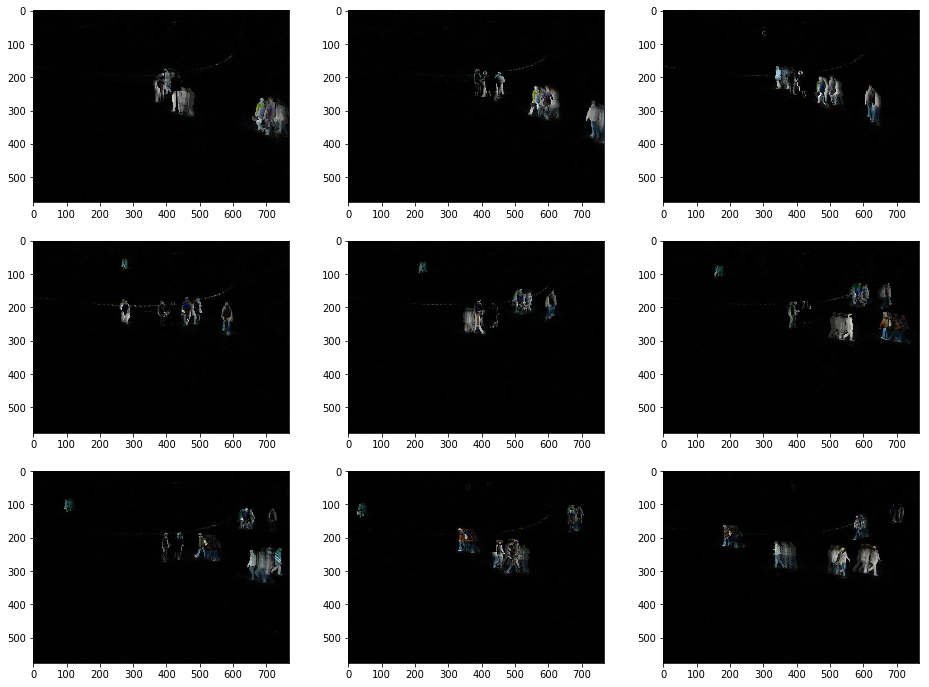

In [4]:
# Mean Filter
cap = cv2.VideoCapture("../resources/bg_sub.mp4")

queue = []
n = 5
wt = 0.2
for i in range(n): queue.append(cap.read()[1])

batch = 0
fig = plt.figure()
fig.set_size_inches(16, 12)

while True:
    frame = cap.read()[1]
    if frame is None: break
    
    bg = queue[0] * wt
    for i in range(1, n): bg += queue[i] * wt
    out = cv2.absdiff(bg.astype(np.uint8), frame)
    
    _ = queue.pop(0)
    queue.append(frame)
    
    batch += 1
    if batch % 20 == 0:
        try:
            plt.subplot(3, 3, batch // 20)
            plt.imshow(out)
        except: break

cap.release()
plt.show()

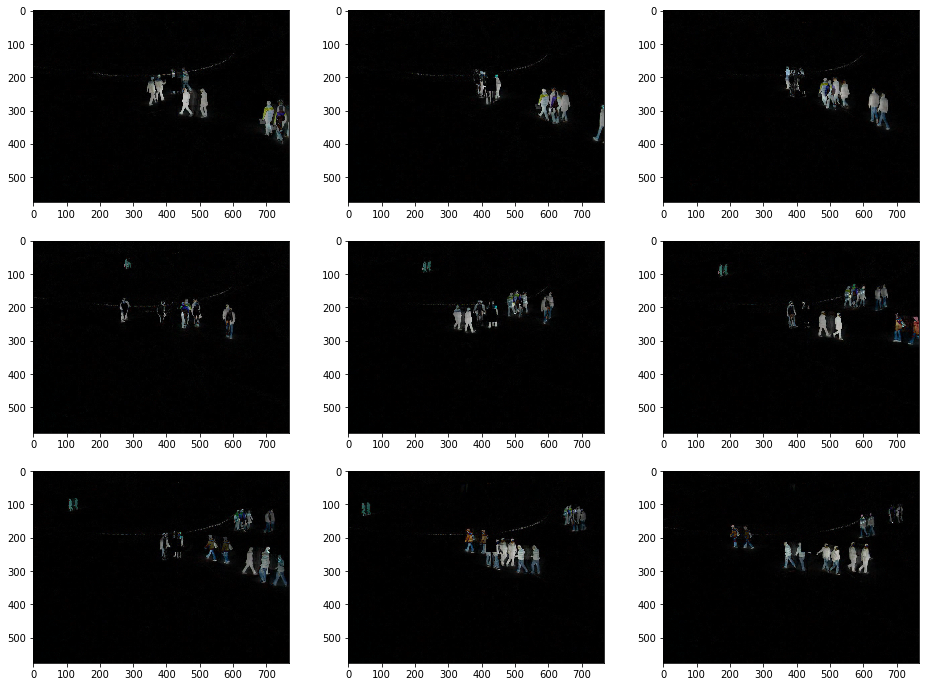

In [5]:
# Running Gaussian Average
cap = cv2.VideoCapture("../resources/bg_sub.mp4")

frame = cap.read()[1]
avg1, avg2 = np.float32(frame), np.float32(frame)

fig = plt.figure()
fig.set_size_inches(16, 12)
batch = 0

while True:
    frame = cap.read()[1]
    if frame is None: break
    
    avg1 = cv2.accumulateWeighted(frame, avg1, 0.1)
    avg2 = cv2.accumulateWeighted(avg1, avg2, 0.01)
    
    res1 = cv2.convertScaleAbs(avg1)
    res2 = cv2.convertScaleAbs(avg2)
    
    res = res1 * 0.9 + res2 * 0.1
    out = cv2.absdiff(res.astype(np.uint8), frame)
    
    batch += 1
    if batch % 5 == 0:  # forgetting the past
        avg1, avg2 = np.float32(frame), np.float32(frame)
    if batch % 20 == 0:
        try:
            plt.subplot(3, 3, batch // 20)
            plt.imshow(out)
        except:
            break
    
cap.release()
plt.show()

# MoG (Mixture of Gaussians)
Mixture of Gaussians method approaches by modelling each pixel as a mixture of Gaussians and uses an on-line approximation to update the model. In this technique, it is assumed that every pixel's intensity values in the video can be modeled using a <a href="http://web.iitd.ac.in/~sumeet/GMM_said_crv10_tutorial.pdf">Gaussian mixture model</a>. A simple heuristic determines which intensities are most probably of the background. Then the pixels which do not match to these are called the foreground pixels. Foreground pixels are grouped using 2D connected component analysis.

- MoG tracks multiple Gaussian Distributions simultaneously
- MoG mantains a density function for each pixel
- Capable of handling multi-modal background distributions
- GMM is a mixture PDF (probability density function), a linear combination of K gaussian PDFs. (∑ w<sub>i</sub> = 1)

1. <b><u>BackgroundSubtractorMOG</u></b> - It uses a method to model each background pixel by a mixture of K Gaussian distributions (K = 3 to 5). The weights of the mixture represent the time proportions that those colours stay in the scene. The probable background colours are the ones which stay longer and more static.

2. <b><u>BackgroundSubtractorMOG2</u></b> - It selects the appropriate number of gaussian distribution for each pixel (we don't have to provide parameter K). It provides better adaptibility to varying scenes due illumination changes etc.

3. <b><u>BackgroundSubtractorGMG</u></b> - This algorithm combines statistical background image estimation and per-pixel Bayesian segmentation. It uses first few (120 by default) frames for background modelling. It employs probabilistic foreground segmentation algorithm that identifies possible foreground objects using Bayesian inference. The estimates are adaptive; newer observations are more heavily weighted than old observations to accommodate variable illumination. Several morphological filtering operations like closing and opening are done to remove unwanted noise. You will get a black window during first few frames. It is better to apply morphological opening to the result to remove the noises.

<b>Functions</b>:
- cv2.bgsegm.createBackgroundSubtractorMOG([, history[, nmixtures[, backgroundRatio[, noiseSigma]]]]) -> retval
- cv2.createBackgroundSubtractorMOG2([, history[, varThreshold[, detectShadows]]]) -> retval
- cv2.bgsegm.createBackgroundSubtractorGMG([, initializationFrames[, decisionThreshold]]) -> retval

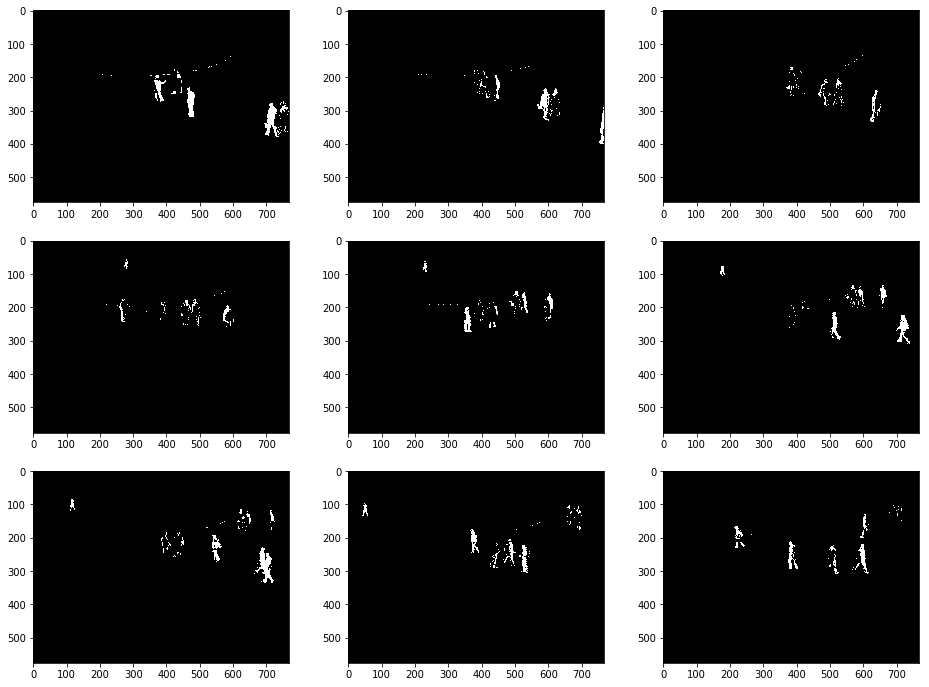

In [6]:
cap = cv2.VideoCapture("../resources/bg_sub.mp4")

fgbg = cv2.bgsegm.createBackgroundSubtractorMOG(history=5, nmixtures=3, backgroundRatio=0.6, noiseSigma=0)

fig = plt.figure()
fig.set_size_inches(16, 12)
batch = 0

while True:
    frame = cap.read()[1]
    if frame is None: break
    
    out = fgbg.apply(frame)
    batch += 1
    if batch % 20 == 0:
        try:
            plt.subplot(3, 3, batch // 20)
            plt.imshow(out, cmap='gray')
        except: break

cap.release()
plt.show()

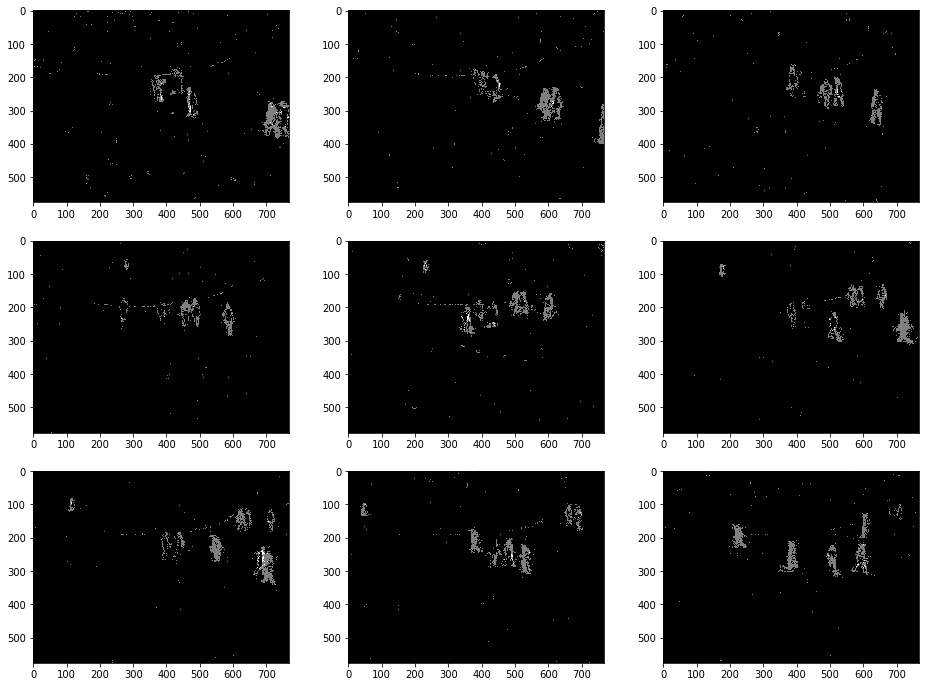

In [7]:
cv2.ocl.setUseOpenCL(False)

cap = cv2.VideoCapture("../resources/bg_sub.mp4")

# Threshold on the squared Mahalanobis distance between the pixel and the model to decide whether a pixel
# is well described by the background model. This parameter does not affect the background update.
fgbg = cv2.createBackgroundSubtractorMOG2(history=5, varThreshold=10, detectShadows=True)

fig = plt.figure()
fig.set_size_inches(16, 12)
batch = 0

while True:
    frame = cap.read()[1]
    if frame is None: break
    
    out = fgbg.apply(frame)
    batch += 1
    if batch % 20 == 0:
        try:
            plt.subplot(3, 3, batch // 20)
            plt.imshow(out, cmap='gray')
        except: break

cap.release()
plt.show()

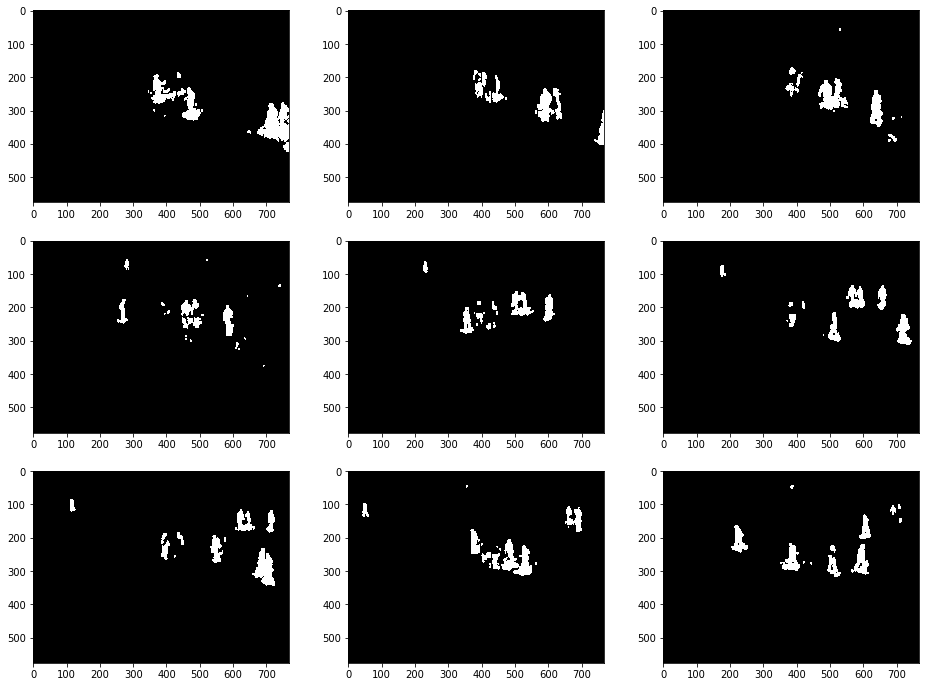

In [8]:
cap = cv2.VideoCapture("../resources/bg_sub.mp4")

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 4))
fgbg = cv2.bgsegm.createBackgroundSubtractorGMG(initializationFrames=5, decisionThreshold=0.7)

fig = plt.figure()
fig.set_size_inches(16, 12)
batch = 0

while True:
    frame = cap.read()[1]
    if frame is None: break
    
    out = fgbg.apply(frame)
    out = cv2.erode(out, kernel, iterations=2)
    out = cv2.dilate(out, kernel, iterations=2)
    batch += 1
    if batch % 20 == 0:
        try:
            plt.subplot(3, 3, batch // 20)
            plt.imshow(out, cmap='gray')
        except: break

cap.release()
plt.show()